In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
pd.set_option('max_rows',None)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
df_train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [12]:
df_train.groupby(["Pclass","Sex"])["Survived"].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

In [51]:
# replace fare=0 with nan
df_train.loc[df_train["Fare"] == 0, "Fare"] = np.NaN
df_test.loc[df_train["Fare"] == 0, "Fare"] = np.NaN

In [52]:
df_train.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [79]:
df_train.groupby(["Embarked","Pclass"]).size()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
dtype: int64

In [82]:
df_train["Title"] = df_train["Name"].apply(lambda x: x.split(",")[1][1:x.split(",")[1][1:].index(" ")])
df_test["Title"] = df_test["Name"].apply(lambda x: x.split(",")[1][1:x.split(",")[1][1:].index(" ")])

In [86]:
df_train["FSize"] = df_train["SibSp"] + df_train["Parch"] + 1
df_test["FSize"] = df_test["SibSp"] + df_test["Parch"] + 1

In [88]:
fsize_survived = df_train.groupby("FSize")["Survived"].mean()

<AxesSubplot:xlabel='FSize'>

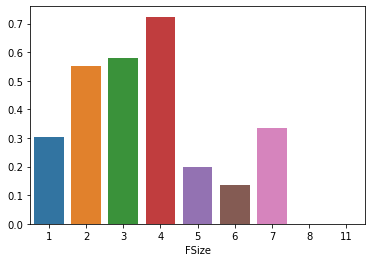

In [89]:
sns.barplot(x=fsize_survived.index,y=fsize_survived.values)

In [97]:
df_train["FType"] = pd.cut(df_train["FSize"],[0,1,4,7,11],labels=["Single", "Medium", "Large", "Very Large"])
df_test["FType"] = pd.cut(df_test["FSize"],[0,1,4,7,11],labels=["Single", "Medium", "Large", "Very Large"])

In [105]:
features = ["Pclass", "Fare", "Title", "Embarked", "FType"]
X = df_train[features]
y = df_train["Survived"]

In [106]:
# PREPROCESSING PIPELINE
quant_cols = ["Fare"]
cat_cols = ["Pclass", "Title", "Embarked", "FType"]

# impute quant cols with median
num_transformer = SimpleImputer(strategy="median")

# impute missing values with most frequent for cat
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing
preprocessor = ColumnTransformer(transformers = [
    ('num',num_transformer,quant_cols),
    ('cat',cat_transformer,cat_cols)
])

# Create pipeline with RF
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0,n_estimators=500,max_depth=5))
])

pipeline.fit(X,y)
print(f"CV: {cross_val_score(pipeline,X,y,cv=10).mean()}")

CV: 0.8193383270911362


In [107]:
X_test = df_test[features]
pred = pipeline.predict(X_test)

In [108]:
out = pd.DataFrame({"PassengerId": df_test.PassengerId, "Survived": pred})
out.to_csv("sub.csv",index=False)